<a href="https://colab.research.google.com/github/mephist0isaloser/real-estate_pred_db/blob/main/real_estate_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Real Estate Price Prediction***

# Import and intro

In [1]:
import pandas as pd



## Loading the dataset

## Refining

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Melbourne_housing_FULL.csv')


## Splitting the data into X and Y

In [3]:
X = df.drop('Price', axis=1)
Y = df['Price']

## Spliting data into numerical and categorical

In [4]:
X_numerical = X.select_dtypes(include=['float', 'int'])  # Select numerical features
X_categorical = X.select_dtypes(include=['object'])  # Select categorical features


## Handling the categorical data

In [5]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_categorical_encoded = encoder.fit_transform(X_categorical)

import numpy as np

X_combined = np.concatenate((X_numerical, X_categorical_encoded), axis=1)


### *Handling the Nan characters for X*

In [6]:
import numpy as np

def simple_imputer_numpy(X, missing_value=np.nan, strategy='mean'):
    if strategy == 'mean':
        X_filled = np.nanmean(X, axis=0)
    elif strategy == 'median':
        X_filled = np.nanmedian(X, axis=0)
    elif strategy == 'most_frequent':
        X_filled = np.nanmax(X, axis=0)
    else:
        raise ValueError("Invalid imputation strategy.")

    mask = np.isnan(X)
    X_imputed = np.where(mask, X_filled, X)

    return X_imputed

X_combined_imputed = simple_imputer_numpy(X_combined, missing_value=np.nan, strategy='mean')

### Handling the NaN for Y

In [7]:
import numpy as np


# Reshape the target variable to have 2D shape
Y_reshaped = Y.values.reshape(-1, 1)

# Apply SimpleImputer to impute missing values
Y_imputed = simple_imputer_numpy(Y_reshaped, missing_value=np.nan, strategy='mean')

# Convert back to 1D array if needed
Y_imputed_1d = np.squeeze(Y_imputed)


## Test and Train split


In [8]:
import numpy as np

def train_test_split_custom(X, y, test_size=0.2, random_state=None):
    # Set random seed if specified
    if random_state is not None:
        np.random.seed(random_state)

    # Shuffle the indices of the data
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    # Determine the split index based on the test size
    split_index = int(len(X) * (1 - test_size))

    # Split the data into training and testing sets
    X_train = X[indices[:split_index]]
    X_test = X[indices[split_index:]]
    y_train = y[indices[:split_index]]
    y_test = y[indices[split_index:]]

    return X_train, X_test, y_train, y_test

X_train, X_test, Y_train, Y_test = train_test_split_custom(X_combined_imputed, Y_imputed_1d, test_size=0.2, random_state=100)

# **LinearRegression**

## Training and predition

In [9]:
import numpy as np

def linear_regression(X, y):
    # Add a column of ones to X for the intercept term
    X = np.column_stack((np.ones((len(X), 1)), X))

    # Calculate the regression coefficients (theta) using the normal equation
    theta = np.linalg.inv(X.T @ X) @ X.T @ y

    return theta

def predict(X, theta):
    # Add a column of ones to X for the intercept term
    X = np.column_stack((np.ones((len(X), 1)), X))

    # Calculate the predicted values
    y_pred = X @ theta

    return y_pred

theta = linear_regression(X_train, Y_train)
Y_test_pred = predict(X_test, theta)
Y_train_pred = predict(X_train, theta)


## Evalvate the model

In [10]:
import numpy as np

def mean_squared_error_custom(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

def r2_score_custom(y_true, y_pred):
    ssr = np.sum((y_true - y_pred) ** 2)
    sst = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ssr / sst)
    return r2

def mean_absolute_error_custom(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    return mae



lr_train_mse = mean_squared_error_custom(Y_train, Y_train_pred)
lr_train_r2 = r2_score_custom(Y_train,Y_train_pred)
lr_train_mae = mean_absolute_error_custom(Y_train, Y_train_pred)

lr_test_mse = mean_squared_error_custom(Y_test, Y_test_pred)
lr_test_r2 = r2_score_custom(Y_test, Y_test_pred)
lr_test_mae = mean_absolute_error_custom(Y_test, Y_test_pred)

In [11]:
lr_results = pd.DataFrame(['Linear regression', lr_train_mse, lr_train_r2,lr_train_mae, lr_test_mse, lr_test_r2, lr_test_mae]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Training R2','Training MAE', 'Test MSE', 'Test R2', 'Test MAE']

lr_results

,Method,Training MSE,Training R2,Training MAE,Test MSE,Test R2,Test MAE
0,Linear regression,192164814909.892639,0.394366,287136.212322,202145259387.482147,0.403664,288711.751864


# **Decision Tree Regression**

In [12]:

import numpy as np

class DecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = {}

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth=0):
        if self.max_depth is not None and depth >= self.max_depth or len(set(y)) == 1:
            return {'leaf': True, 'value': np.mean(y)}

        best_feature_index, best_threshold = self._find_best_split(X, y)
        left_indices = X[:, best_feature_index] <= best_threshold
        right_indices = X[:, best_feature_index] > best_threshold

        left_branch = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_branch = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'leaf': False, 'feature_index': best_feature_index,
                'threshold': best_threshold, 'left': left_branch, 'right': right_branch}

    def _find_best_split(self, X, y):
        best_gain = -float('inf')
        best_feature_index = None
        best_threshold = None

        for feature_index in range(X.shape[1]):
            feature_values = X[:, feature_index]
            unique_values = np.unique(feature_values)
            for value in unique_values:
                left_indices = feature_values <= value
                right_indices = feature_values > value
                gain = self._calculate_gain(y, y[left_indices], y[right_indices])
                if gain > best_gain:
                    best_gain = gain
                    best_feature_index = feature_index
                    best_threshold = value

        return best_feature_index, best_threshold

    def _calculate_gain(self, parent, left_child, right_child):
        return self._mse(parent) - (len(left_child) / len(parent)) * self._mse(left_child) - \
               (len(right_child) / len(parent)) * self._mse(right_child)

    def _mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)

    def _traverse_tree(self, x, node):
        if node['leaf']:
            return node['value']
        if x[node['feature_index']] <= node['threshold']:
            return self._traverse_tree(x, node['left'])
        else:
            return self._traverse_tree(x, node['right'])

# Create and train the Decision Tree Regression model
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, Y_train)

# Make predictions on the testing data
Y_dtr_test_pred = model.predict(X_test)
Y_dtr_train_pred = model.predict(X_train)


Y_dtr_test_pred,Y_test, Y_dtr_train_pred, Y_train

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([ 627428.21120744, 1136058.99481548, 1136058.99481548, ...,
         679632.45530424, 1534134.94275438,  822092.22557363]),
 array([ 555000., 1291000., 1317500., ...,  720000., 1975000.,  815000.]),
 array([1399370.83245497, 1075147.02282286, 1136058.99481548, ...,
        1203026.86513788,  895267.22684436,  822092.22557363]),
 array([1880000.,  900000.,  970000., ..., 1270000.,  730000.,  790000.]))

##  Evalvation

In [13]:
dtr_train_mse = mean_squared_error_custom(Y_train, Y_dtr_train_pred)
dtr_train_r2 = r2_score_custom(Y_train,Y_dtr_train_pred)
dtr_train_mae = mean_absolute_error_custom(Y_train, Y_dtr_train_pred)

dtr_test_mse = mean_squared_error_custom(Y_test, Y_dtr_test_pred)
dtr_test_r2 = r2_score_custom(Y_test, Y_dtr_test_pred)
dtr_test_mae = mean_absolute_error_custom(Y_test, Y_dtr_test_pred)

In [14]:
dtr_results = pd.DataFrame(['Decision Tree Regression', dtr_train_mse, dtr_train_r2,dtr_train_mae, dtr_test_mse, dtr_test_r2, dtr_test_mae]).transpose()
dtr_results.columns = ['Method', 'Training MSE', 'Training R2','Training MAE', 'Test MSE', 'Test R2', 'Test MAE']

dtr_results

,Method,Training MSE,Training R2,Training MAE,Test MSE,Test R2,Test MAE
0,Decision Tree Regression,176842989765.158966,0.442654,272146.967428,193521999186.648956,0.429102,278172.947083


#  KNN

In [15]:
import numpy as np

class KNNRegressor:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            distances = np.linalg.norm(self.X_train - x, axis=1)  # Euclidean distance
            indices = np.argsort(distances)[:self.k]  # Indices of k nearest neighbors
            k_nearest_labels = self.y_train[indices]  # Labels of k nearest neighbors
            prediction = np.mean(k_nearest_labels)  # Average of nearest neighbors' labels
            predictions.append(prediction)
        return np.array(predictions)

# Create and train the KNNRegressor model
model = KNNRegressor(k=5)
model.fit(X_train, Y_train)

# Make predictions on the testing data
Y_KNN_test_pred = model.predict(X_test)
Y_KNN_train_pred = model.predict(X_train)

Y_KNN_test_pred, Y_test, Y_KNN_train_pred, Y_train

(array([1366600.        , 1121634.66899108, 1224569.33798216, ...,
         947069.33798216, 1313069.33798216, 1366600.        ]),
 array([ 555000., 1291000., 1317500., ...,  720000., 1975000.,  815000.]),
 array([1006600.        ,  936300.        ,  959569.33798216, ...,
         917034.66899108, 1106834.66899108,  987269.33798216]),
 array([1880000.,  900000.,  970000., ..., 1270000.,  730000.,  790000.]))

## Evalvation

In [16]:
KNN_train_mse = mean_squared_error_custom(Y_train, Y_KNN_train_pred)
KNN_train_r2 = r2_score_custom(Y_train,Y_KNN_train_pred)
KNN_train_mae = mean_absolute_error_custom(Y_train, Y_KNN_train_pred)

KNN_test_mse = mean_squared_error_custom(Y_test, Y_KNN_test_pred)
KNN_test_r2 = r2_score_custom(Y_test, Y_KNN_test_pred)
KNN_test_mae = mean_absolute_error_custom(Y_test, Y_KNN_test_pred)

In [17]:
KNN_results = pd.DataFrame(['Decision Tree Regression', KNN_train_mse, KNN_train_r2,KNN_train_mae, KNN_test_mse, KNN_test_r2, KNN_test_mae]).transpose()
KNN_results.columns = ['Method', 'Training MSE', 'Training R2','Training MAE', 'Test MSE', 'Test R2', 'Test MAE']

KNN_results

,Method,Training MSE,Training R2,Training MAE,Test MSE,Test R2,Test MAE
0,Decision Tree Regression,186058144415.710876,0.413612,285021.283685,293974949620.818359,0.132762,355592.871536


# Comparision of the models

In [18]:
df_models = pd.concat([lr_results, dtr_results, KNN_results ], axis=0)
df_models

,Method,Training MSE,Training R2,Training MAE,Test MSE,Test R2,Test MAE
0,Linear regression,192164814909.892639,0.394366,287136.212322,202145259387.482147,0.403664,288711.751864
0,Decision Tree Regression,176842989765.158966,0.442654,272146.967428,193521999186.648956,0.429102,278172.947083
0,Decision Tree Regression,186058144415.710876,0.413612,285021.283685,293974949620.818359,0.132762,355592.871536


# Data visualisation

[]

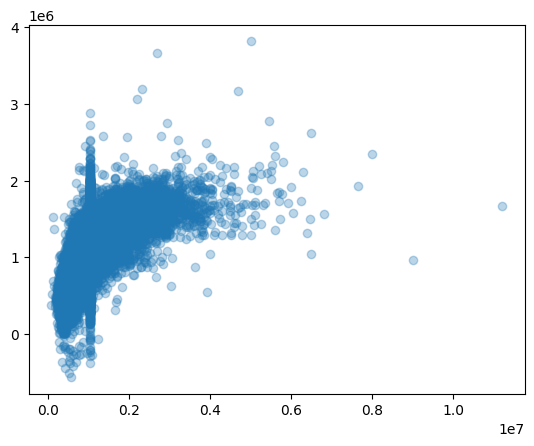

In [19]:
import matplotlib.pyplot as plt
plt.scatter(x=Y_train, y=Y_train_pred, alpha=0.3)
plt.plot()

[]

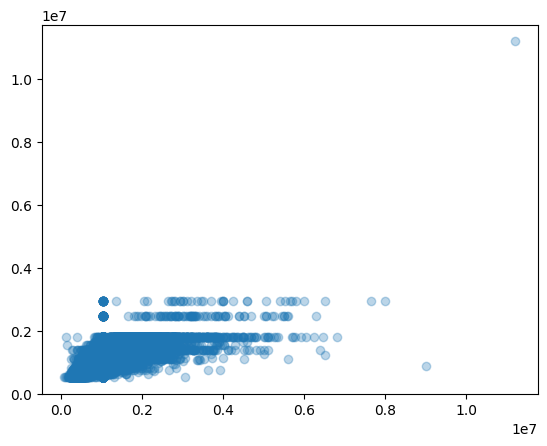

In [20]:
import matplotlib.pyplot as plt
plt.scatter(x=Y_train, y=Y_dtr_train_pred, alpha=0.3)
plt.plot()

[]

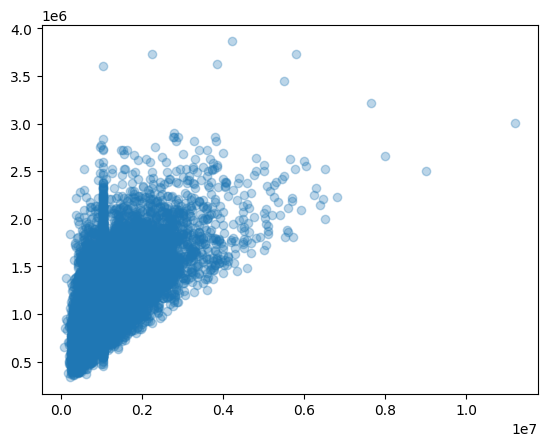

In [21]:
import matplotlib.pyplot as plt
plt.scatter(x=Y_train, y=Y_KNN_train_pred, alpha=0.3)
plt.plot()

# EDA

(63023, 13)
Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Postcode', 'Regionname', 'Propertycount', 'Distance',
       'CouncilArea'],
      dtype='object')
         Suburb           Address  Rooms Type      Price Method   SellerG  \
0    Abbotsford     49 Lithgow St      3    h  1490000.0      S    Jellis   
1    Abbotsford     59A Turner St      3    h  1220000.0      S  Marshall   
2    Abbotsford     119B Yarra St      3    h  1420000.0      S    Nelson   
3    Aberfeldie        68 Vida St      3    h  1515000.0      S     Barry   
4  Airport West  92 Clydesdale Rd      2    h   670000.0      S    Nelson   

        Date  Postcode             Regionname  Propertycount  Distance  \
0  1/04/2017      3067  Northern Metropolitan           4019       3.0   
1  1/04/2017      3067  Northern Metropolitan           4019       3.0   
2  1/04/2017      3067  Northern Metropolitan           4019       3.0   
3  1/04/2017      3040   Western Metrop

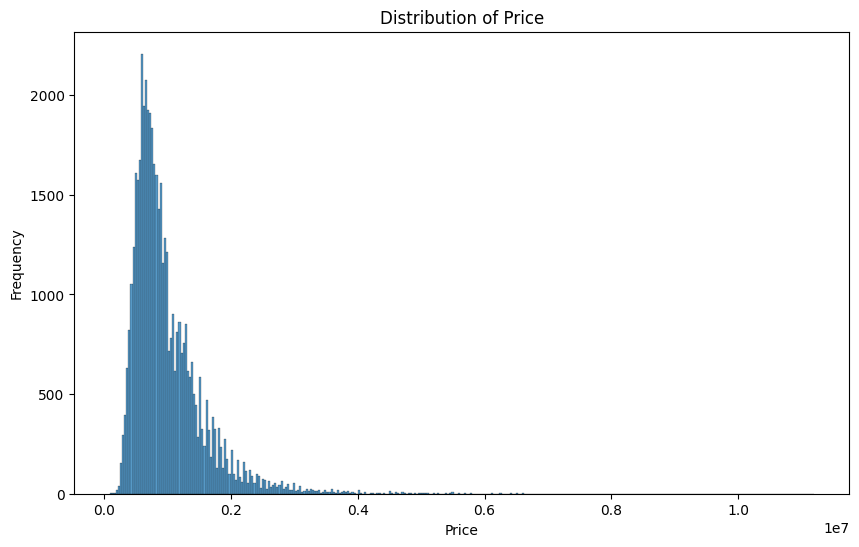

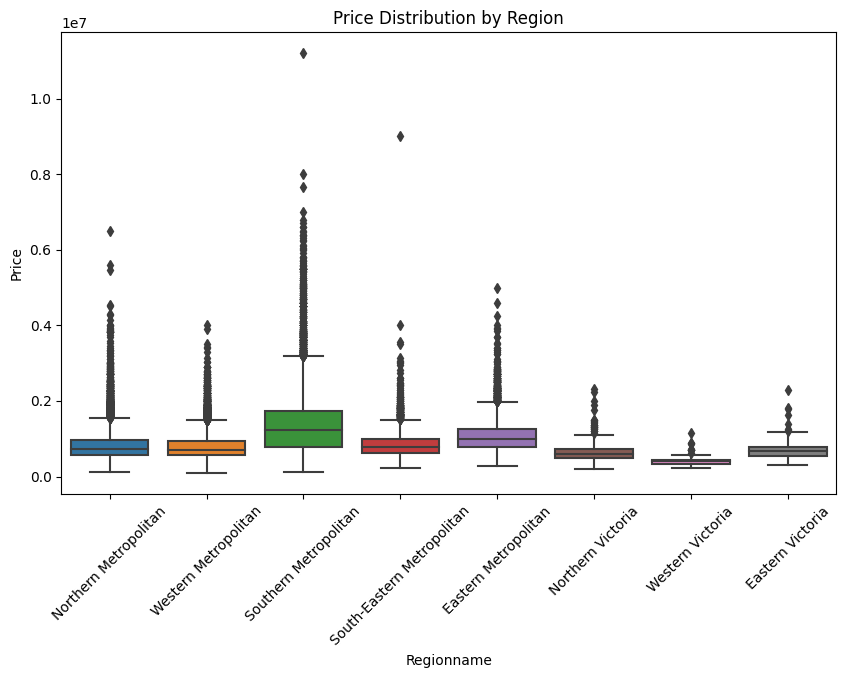

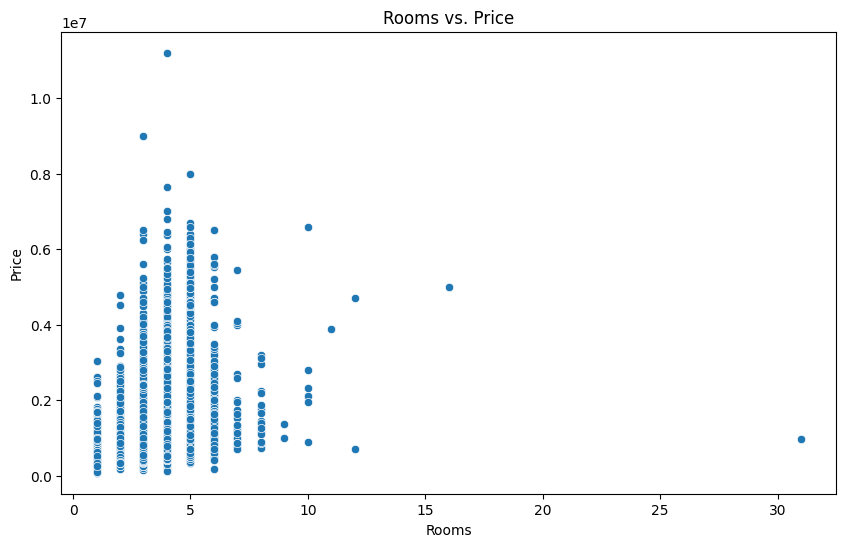

<ipython-input-22-afba5a1909e0>:44: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


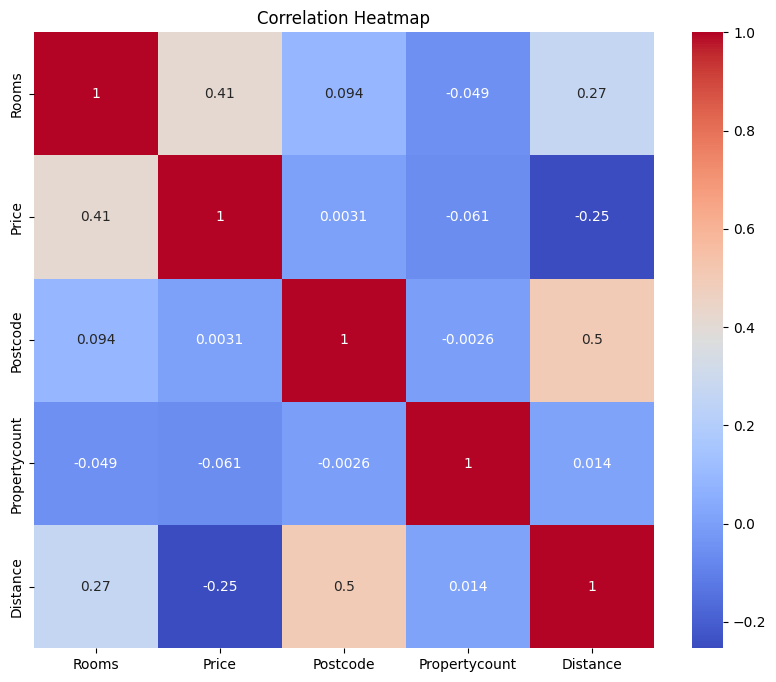

<ipython-input-22-afba5a1909e0>:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Type', y='Price', ci=None)


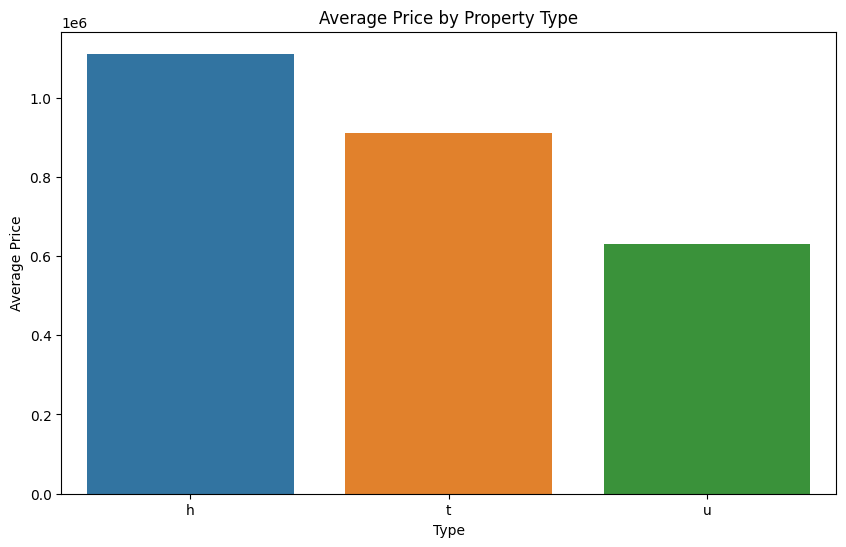

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MELBOURNE_HOUSE_PRICES_LESS.csv')

# Explore the basic properties of the data
print(df.shape)  # Check dimensions of the dataset
print(df.columns)  # Check column names
print(df.head())  # Print the first few rows of the dataset

# Summary statistics
print(df.describe())  # Basic statistics for numerical features

# Data Visualization
# Histogram of Price
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'])
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

# Box plot of Price by Regionname
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Regionname', y='Price')
plt.xlabel('Regionname')
plt.ylabel('Price')
plt.title('Price Distribution by Region')
plt.xticks(rotation=45)
plt.show()

# Scatter plot of Rooms vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Rooms', y='Price')
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Rooms vs. Price')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Feature Analysis
# Average Price by Type
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Type', y='Price', ci=None)
plt.xlabel('Type')
plt.ylabel('Average Price')
plt.title('Average Price by Property Type')
plt.show()

# Data Cleaning and Preprocessing
# Handle missing values, outliers, and other data cleaning tasks

# Feature Engineering
# Create new features based on domain knowledge or data insights

# Machine Learning Model
# Prepare the data and build your machine learning model to predict real estate prices
# Split the dataset into features (X) and target variable (y)
# Perform train-test split using train_test_split() function from sklearn
# Build your machine learning model, train it on the training data, and evaluate its performance

# Further Data Analysis and Model Evaluation
# Continue with additional data analysis, feature selection, hyperparameter tuning, etc.
# Evaluate the model using appropriate metrics such as mean squared error (MSE), R-squared, etc.


# ***deep learning***

In [23]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_combined_imputed, Y_imputed_1d, epochs=10, batch_size=32)

# Make predictions
pred_dl_test = model.predict(X_test)
pred_dl_train = model.predict(X_train)
# Evaluate the model (optional)
# loss = model.evaluate(X_test, y_test)

Epoch 1/10
1090/1090 [==============================] - 5s 3ms/step - loss: 475165491200.0000
Epoch 2/10
1090/1090 [==============================] - 4s 4ms/step - loss: 341619769344.0000
Epoch 3/10
1090/1090 [==============================] - 3s 2ms/step - loss: 331696242688.0000
Epoch 4/10
1090/1090 [==============================] - 3s 2ms/step - loss: 327693500416.0000
Epoch 5/10
1090/1090 [==============================] - 3s 2ms/step - loss: 321624997888.0000
Epoch 6/10
1090/1090 [==============================] - 3s 3ms/step - loss: 321585414144.0000
Epoch 7/10
1090/1090 [==============================] - 4s 3ms/step - loss: 318879891456.0000
Epoch 8/10
1090/1090 [==============================] - 3s 3ms/step - loss: 314840875008.0000
Epoch 9/10
1090/1090 [==============================] - 3s 2ms/step - loss: 313744785408.0000
Epoch 10/10
872/872 [==============================] - 1s 2ms/step


## Evalvation

In [ ]:
dl_train_mse = mean_squared_error_custom(Y_train, pred_dl_train)
dl_train_r2 = r2_score_custom(Y_train,pred_dl_train)
dl_train_mae = mean_absolute_error_custom(Y_train, pred_dl_train)

dl_test_mse = mean_squared_error_custom(Y_test, pred_dl_test)
dl_test_r2 = r2_score_custom(Y_test, pred_dl_test)
dl_test_mae = mean_absolute_error_custom(Y_test, pred_dl_test)

In [ ]:
dl_results = pd.DataFrame(['Deep Learning', dl_train_mse, dl_train_r2,dl_train_mae, dl_test_mse, dl_test_r2, dl_test_mae]).transpose()
dl_results.columns = ['Method', 'Training MSE', 'Training R2','Training MAE', 'Test MSE', 'Test R2', 'Test MAE']

dtr_results